## Reserved for library installs

In [1]:
!pip3 install pillow

Defaulting to user installation because normal site-packages is not writeable


### Imports

In [2]:
import argparse
from collections import Counter
import datetime
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision.transforms.functional import normalize, to_tensor, resize, to_pil_image
from torchvision.io.image import read_image
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import BatchSizeFinder, EarlyStopping, LearningRateFinder
from pytorch_lightning import Trainer

from torchcam.utils import overlay_mask
from torchcam.methods import SmoothGradCAMpp

import config
import model

from dataset import createConfusionMatrix
from dataset import MixtecGenders
from model import MixtecModel

/apps/pytorch/2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def _printdate(dt=datetime.datetime.now()):
    """print a date and time string containing only numbers and dashes"""

    # your code here
    if dt.hour < 10:
        hour = "0" + str(dt.hour)
    else:
        hour = str(dt.hour)

    if dt.minute < 10:
        minute = "0" + str(dt.minute)
    else:
        minute = str(dt.minute)

    d = "{}-{}-{}-{}-{}".format(str(dt.month), str(dt.day), str(dt.year), hour, minute)
    return d

In [4]:
class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        pl_module.logger.log_metrics(metrics, step=trainer.global_step)
        for k, v in metrics.items():
            pl_module.logger.log_metrics({k: v}, step=trainer.global_step)
            pl_module.logger.experiment.add_scalar(k, v, trainer.global_step)

In [5]:
# Get the data set
# Using only one worker is faster
dataset = MixtecGenders(num_workers=1, batch_size=config.BATCH_SIZE)

#print(dict(Counter(dataset.targets)))

logger = TensorBoardLogger(save_dir="../runs", name="cam_test", default_hp_metric=False)

# Configure the model
#model = NN(config.BATCH_SIZE, config.LEARNING_RATE)
model = MixtecModel(learning_rate=config.LEARNING_RATE, num_epoch=config.EPOCHS, model_name="resnet18")
# model.set_reference_dataloader(dataset.reference_dataloader)

In [6]:
# Train the model
early_stopping = EarlyStopping(
    monitor="val_f1",
    # min_delta=1e-6,
    stopping_threshold=1e-4,
    # divergence_threshold=9.0,
    check_finite=True,
)

In [7]:
trainer = Trainer(devices="auto", accelerator="auto", #auto_lr_find=True,
                    logger=logger, log_every_n_steps=1, enable_progress_bar=True,
                    min_epochs=1, max_epochs=config.EPOCHS,
                    callbacks=[
                    #   BatchSizeFinder(init_val=64),
                    # LearningRateFinder(),
                    #early_stopping,
                    # LoggingCallback(),
                        ])

# Tune the model
# trainer.tune(model, datamodule=dataset)


# Run the evaluation

fitresults = trainer.fit(model, datamodule=dataset)

# Create and log confusion matrix
logger.experiment.add_figure("Confusion matrix", createConfusionMatrix(dataset.train_dataloader(), model), config.EPOCHS)
logger.experiment.add_figure("Confusion matrix", createConfusionMatrix(dataset.val_dataloader(), model), config.EPOCHS)

valresults = trainer.validate(model, datamodule=dataset)
print('-'*80)
print(f"{valresults=}")
print('-'*80)
#print(trainer.predict(model, datamodule=dataset))
#trainer.test(model, dm)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training Set: Counter({1: 548, 0: 224})
Validation Set: Counter({1: 268, 0: 117})


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | model         | ResNet           | 11.2 M
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/home/alexwebber/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/alexwebber/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


self.test_metrics.compute(): {'val_acc': tensor(0.3320, device='cuda:0'), 'val_f1': tensor(0.1407, device='cuda:0'), 'val_prec': tensor(0.9333, device='cuda:0'), 'val_rec': tensor(0.0761, device='cuda:0')}
Validation finished!


/home/alexwebber/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s, v_num=5]38it/s]
                                                                      self.test_metrics.compute(): {'val_acc': tensor(0.6961, device='cuda:0'), 'val_f1': tensor(0.8208, device='cuda:0'), 'val_prec': tensor(0.6961, device='cuda:0'), 'val_rec': tensor(1., device='cuda:0')}
Validation finished!
Epoch 0: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s, v_num=5]
Training Set: Counter({1: 548, 0: 224})


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation Set: Counter({1: 265, 0: 120})


/home/alexwebber/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/alexwebber/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
self.test_metrics.compute(): {'val_acc': tensor(0.6935, device='cuda:0'), 'val_f1': tensor(0.8179, device='cuda:0'), 'val_prec': tensor(0.6919, device='cuda:0'), 'val_rec': tensor(1., device='cuda:0')}
Validation finished!
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.6935064792633057
      val_f1_epoch          0.8179012537002563
     val_prec_epoch         0.6919060349464417
      val_rec_epoch                 1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--------------------------------------------------------------------------------
valresults=[{'val_acc_epoch': 0.69350

torch.Size([3, 224, 224])


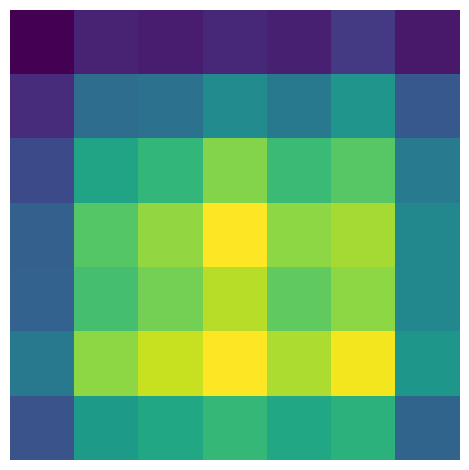

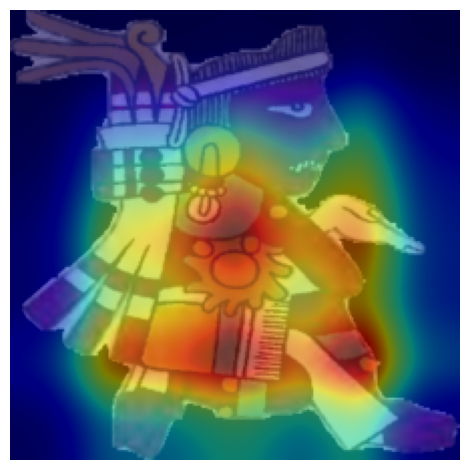

In [9]:
# Run the test
img = Image.open("../reference_images/male/067-a-09.png")
to_tensor        = transforms.ToTensor()
to_square        = transforms.Resize((224, 224), antialias=True)
to_three_channel = transforms.Lambda(lambda x: x[:3])

img              = to_three_channel(to_square(to_tensor(img)))

print(img.shape)

# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

cam_extractor = SmoothGradCAMpp(model)
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    

plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
    
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()